In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
from operator import itemgetter

%matplotlib inline

In [67]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import DistanceMetric, NearestNeighbors

In [4]:
from utils import *

In [5]:
df = pd.read_csv('../../data/geohash/top_active_device_data.csv')
X = np.array(list(zip(df['lat'], df['long'])))

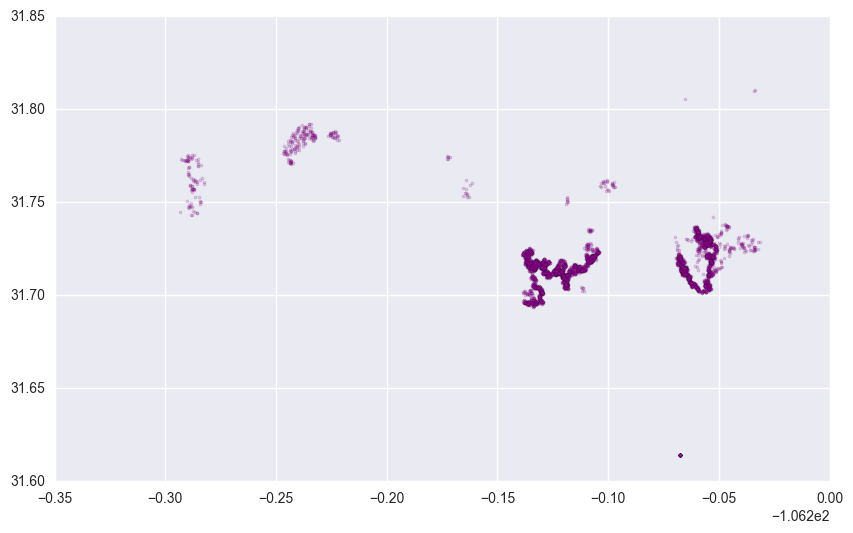

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(df['long'], df['lat'], c='m', edgecolor='k', alpha=.2, s=5)

## K-Means

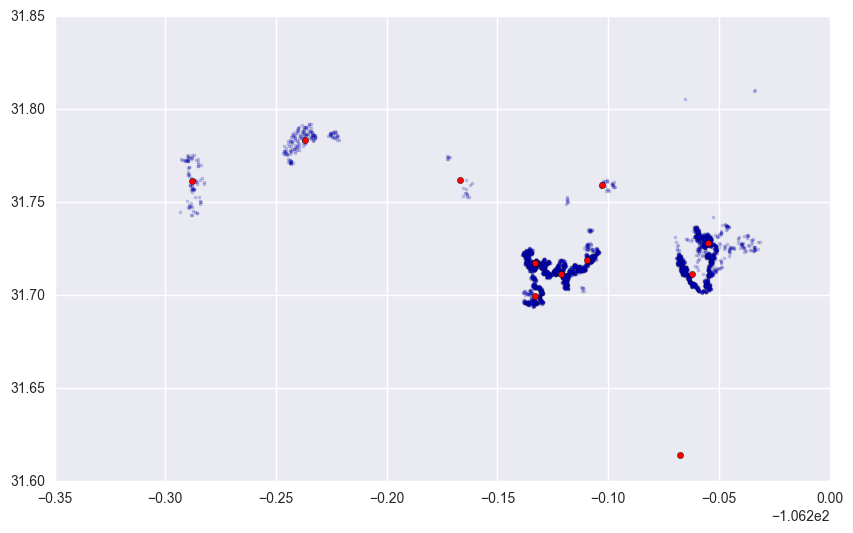

In [11]:
kmeans = KMeans(n_clusters=11).fit(X)

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(df['long'], df['lat'], c='b', edgecolor='k', alpha=.2, s=5)

for y,x in kmeans.cluster_centers_:
    ax.scatter(x,y, c='red')

# DBSCAN

## Determining epsilon, min_pts parameters

In [148]:
def dist2NN(X):
    '''
    Distance to Nearest Neighbor of precomputed distance matrix X
    '''
    return [sorted(row)[1] for row in X]

def pairwise_distance(X):
    df = pd.DataFrame(X).drop_duplicates()
    return df, squareform(pdist(df, lambda u,v: haversine(u,v)))

def count_elems_lt(array, threshold):
    return len([elem for elem in array if elem <= threshold])

def count_neighbors(X, epsilon):
    '''
    Count neighbors lying in point's epsilon-neighborhood
    '''
    return [count_elems_lt(row, epsilon) for row in X]

### 1. epsilon

In [ ]:
X_pairwise = squareform(pdist(X, lambda u,v: haversine(u,v)))
dist2nn = dist2NN(X_pairwise)

In [152]:
np.percentile(dist2nn, 75)

0.01994040571293133

In [154]:
np.percentile(dist2nn, 90)

0.033334878938903599

(0, 0.2)

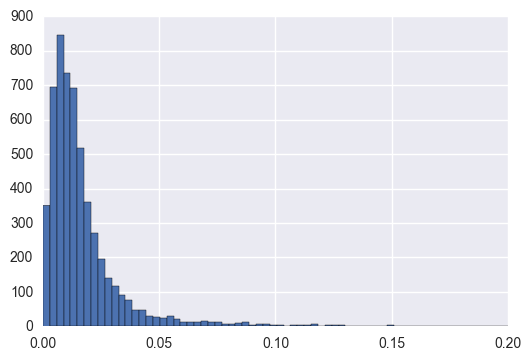

In [153]:
fig, ax = plt.subplots()
ax.hist(dist2nn, bins=1000)
plt.xlim(0, 0.2)

(0, 0.05)

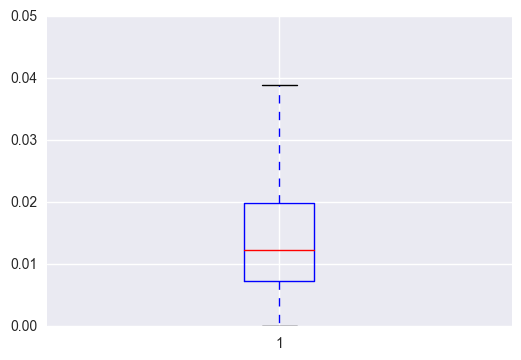

In [159]:
fig, ax = plt.subplots()
ax.boxplot(dist2nn)
plt.ylim(0, 0.05)

### 2. min_pts

In [155]:
neighbors_eps = count_neighbors(X_pairwise, 0.2)

/Users/johnmin/src/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


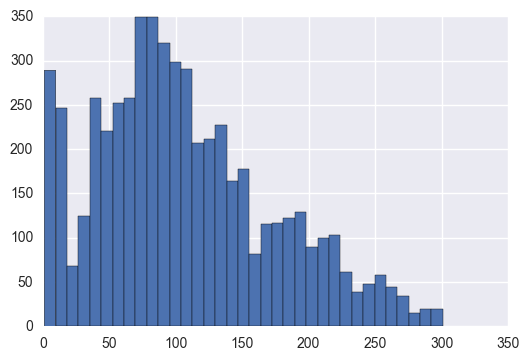

In [171]:
fig, ax = plt.subplots()
ax.hist(neighbors_eps, bins=35)
fig.show()

/Users/johnmin/src/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


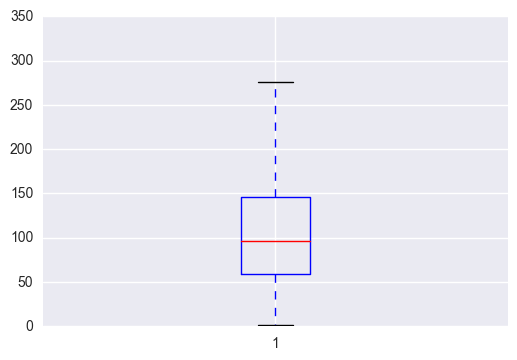

In [169]:
fig, ax = plt.subplots()
ax.boxplot(neighbors_eps)
fig.show()

## Implement sklearn.cluster.DBSCAN

In [140]:
#KM_TO_RADIANS=6371
#eps_search = map(lambda x: x/KM_TO_RADIANS, [])
eps_search = [0.005, 0.01, .015, .020, .025, .03]
min_samples_search = [5, 10, 25, 50, 100]

In [144]:
def dbscan_grid_search(X, eps_search=[0.1], min_samples_search=[10]):
    results = []
    for e,n in itertools.product(eps_search, min_samples_search):
        try:
            db = DBSCAN(eps=e, min_samples=n, metric='haversine').fit(X)
            labels = db.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            silhouette_coef = metrics.silhouette_score(X, labels)
            results.append((e,n,n_clusters_,silhouette_coef, db))
        except:
            #results.append((e,n,n_clusters_,None))
            results.append((e,n,n_clusters_,0,0)) #put 0 instead of None for result comparison
    return results

In [149]:
def find_best_result(results, idx=3):
    return max(results, key=itemgetter(idx))

In [145]:
dbscan_results = dbscan_grid_search(X, eps_search, min_samples_search)

In [132]:
#db = DBSCAN(eps=.02, min_samples=25, metric='haversine').fit(X)
db = find_best_result(dbscan_results)[5]
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
'''
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
'''
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 5
Silhouette Coefficient: 0.775


/Users/johnmin/src/anaconda3/lib/python3.5/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


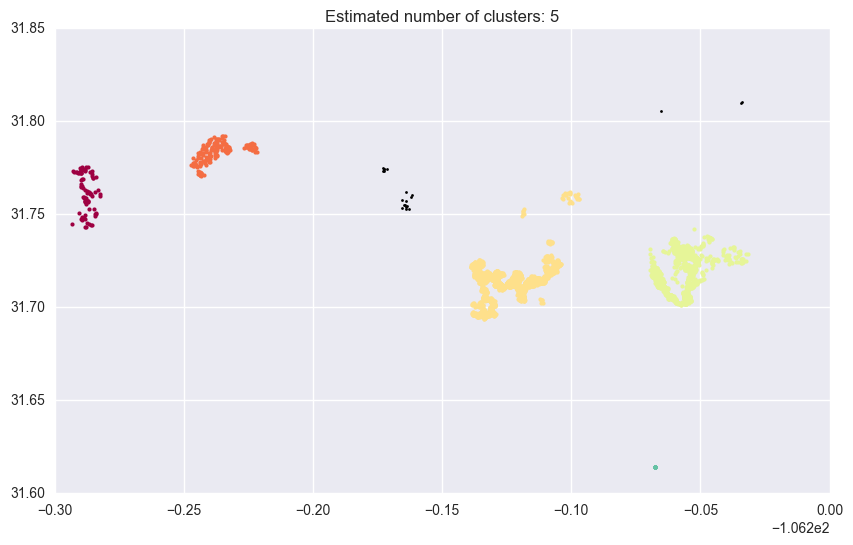

In [139]:
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=3)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()